# Índice
1. [Módulos](#Módulos)
1. [Exploración](#Lectura-y-exploración-de-datos)
    - [Etiquetas](#Clases)
    - [Nulos](#Nulos)
    - [Tiempo](#Popularidad-respecto-al-tiempo)
    - [Preparación](#Preparación-de-los-datos)
1. [Visualización](#Análisis-y-visualizaciones)
1. [Modelos](#Modelos)
    - [Regresión lineal](#Regresión-lineal)
    - [Regresión polinomial](#Polinomial)
    - [K vecinos](#K-nn-regressor)
    - [Árboles de decisión](#Árbol-de-decisión)
    - [Random forests](#Random-Forest)
    - [Gradient Boosting Trees](#GBT)
    - [Light Gradient Boosting Machine](#LGBM)
    
1. [Búsqueda de hiperparámetros](#Búsqueda-de-hiperpárametros)
1. [Interpretación](#Interpretación)

# Módulos

In [12]:
# Data science
import pandas as pd
import numpy as np

# División de datos
from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler # Preprocesamiento

# Reducción de dimensionalidad
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import r2_score # métrica

# Modelos
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# visualización
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import seaborn as sns

# Lectura y exploración de datos

In [4]:
data = pd.read_csv("../spotify/data.csv")
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


# Datos 

**Acústica(acousticness):**
Variable numerica de confianza que va de 0 a 1 y señala que tan acustica es una cancion, una puntuacion de 1.0 indica que una cancion tiene altas posibilidades de ser acustica.

**Instrumentalidad(instrumentalness):**
Variable que cuantifica el nivel de voces dentro de una cancion es decir si la variable se acerca a 0 la cancion tiene muchas voces y entre mas cerca este de 1 mas instrumental es, la cancion se compone solo de instrumentos.

**Capacidad de baile o bailabilidad (danceability):**
Variable numerica entre 0 a 1, describe qué tan adecuada es una pista para bailar en función de una combinación de elementos musicales que incluyen el tempo, la estabilidad del ritmo, la fuerza del ritmo y la regularidad general. Entre mas cercano sea a uno el valor de una cancion mas bailable es una cancion.

**Duracion en milisegundos(Duration_ms):**
Variable numerica con la duracion de la cancion en milisegundos.

**Energia (energy):**
Variable que cuantifica una medida perceptiva de intensidad y actividad. Las canciones con un valor cercano a 1 tienden a tener un tempo rapido y ruidoso mientras que las canciones con un numero cercano a 0 son mas tranquilos.

**Explicito (explicit):**
Variable que expresa si una cancion cuenta con palabras consideradas antisonantes u ofensivas en donde si se tiene un valor de 0 la cancion no es explicita y con un valor de 1 la cancion si tiene contenido explicito.

**ID:**
ID de identificacion unico asignado por spotify que involucra tanto variables numericas como alfabeticas del tipo string 

**Instrumentalidad(instrumentalness):**
Variable que cuantifica el nivel de voces dentro de una cancion es decir si la variable se acerca a 0 la cancion tiene muchas voces y entre mas cerca este de 1 mas instrumental es, la cancion se compone solo de instrumentos.

**LLave(Key):**
la clave general estimada de la pista. Los enteros se asignan a los tonos utilizando la notación estándar de clase de tono. Por ejemplo, 0 = C, 1 = C♯ / D ♭, 2 = D, y así sucesivamente.

**Vivacidad (liveness):**
Vatiable que refleja la presencia de una audiencia en la grabación. Los valores mas cercanos a uno representan una mayor probabilidad de que la pista se haya interpretado en vivo.

**Volumen(loudness):** 
La sonoridad general es el promedio de decibelios (dB), se toman los valores de decibelios durante toda la cancion y se promedian ese promedio es el que se ve reflejado en el valor.

**Mode(Modo):**
Representa el contenido melodico dentro de una cancion entre mas cercano a uno sea mas melodica es la cancion.

**Nombre(Name):**
Variable de tipo string que representa el nombre de la cancion.

**Popularidad (Popularity):**
Variable que cuantifica que tan popular es una cancion del 0 al 100 donde 0 es muy impopular y 100 es muy popular
tomando en cuenta.

**Fecha de lanzamiento(release_date):** 
Fecha en que fue lanzada la canción algunas cuentan con el formato e informacion de año mes y dia aunque algunas canciones solo cuentan con la informacion del dia.

**Discurso(speechiness):**
Si el habla de una canción es superior a 0,66, probablemente esté compuesta de palabras habladas, una puntuación entre 0,33 y 0,66 es una canción que puede contener tanto música como palabras, y una puntuación inferior a 0,33 significa que la canción no tiene ningún habla.

**Tempo:** 
Variable que representa la velocidad de la cancion entre mas cercano a 0 mas tranquila es la cancion y entre mas cercano a uno mas rapida es la cancion. 

**Valencia (Valence):**
Una medida de 0.0 a 1.0 que describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más negativas (por ejemplo, triste, deprimido, enojado).

**Año(Year)**:
Año de lanzamiento de la cancion.



## Pequeña visualizacion de algunas relaciones de datos

In [9]:
data = pd.read_csv("../spotify/data.csv")
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']
feature_names1 = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year','popularity']

In [10]:
X = data[feature_names1]
person= X.corr(method = "pearson")
coef_popularity= person.popularity
def_list= coef_popularity.tolist()
def_list.remove(1.0)

Text(0, 0.5, 'Variables')

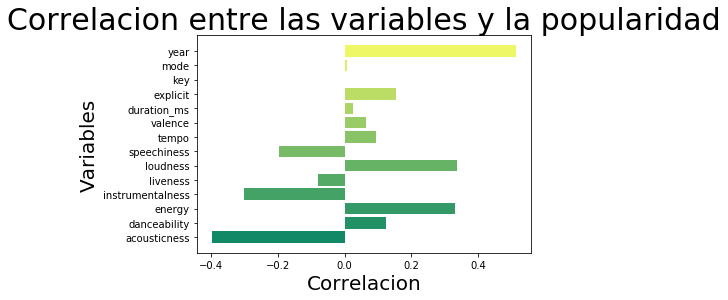

In [14]:
plt.barh(feature_names,def_list, color = sns.color_palette("summer",len(feature_names)))
plt.title('Correlacion entre las variables y la popularidad', fontweight = 30, fontsize = 30)
plt.xlabel('Correlacion',fontsize = 20)
plt.ylabel('Variables',fontsize = 20)

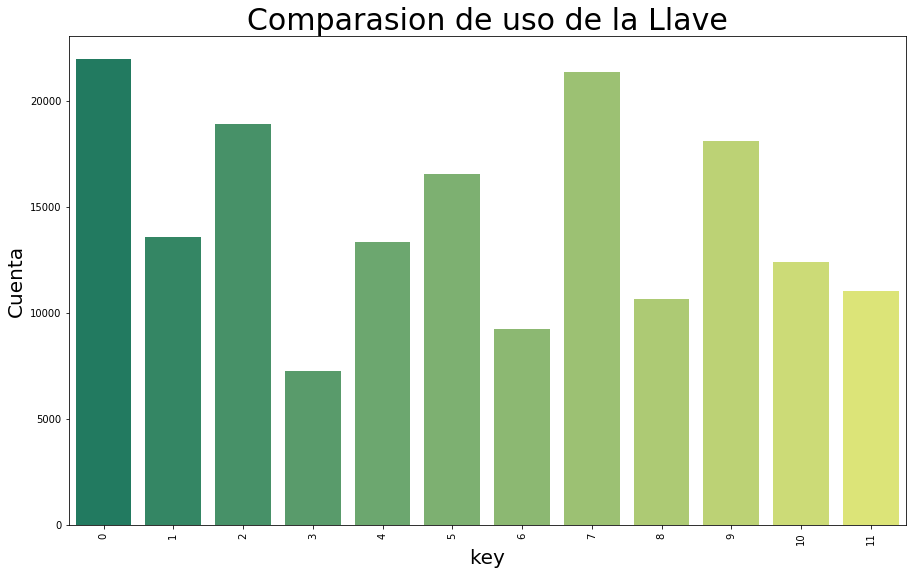

In [15]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('tableau-colorblind10')

sns.countplot(data['key'], palette = 'summer')

plt.title('Comparasion de uso de la Llave', fontweight = 30, fontsize = 30)
plt.xlabel('key',fontsize = 20)
plt.ylabel('Cuenta',fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

**Popularidad promedio por año**

In [16]:
popularidad = []
for i in range (1920,2022):
    filtrar = data[data['year'] == i]
    promedio = filtrar.popularity.mean()
    popularidad.append(promedio )

In [17]:
año = sorted(list(data.year.unique()))

Text(0, 0.5, 'Promedio de popularidad')

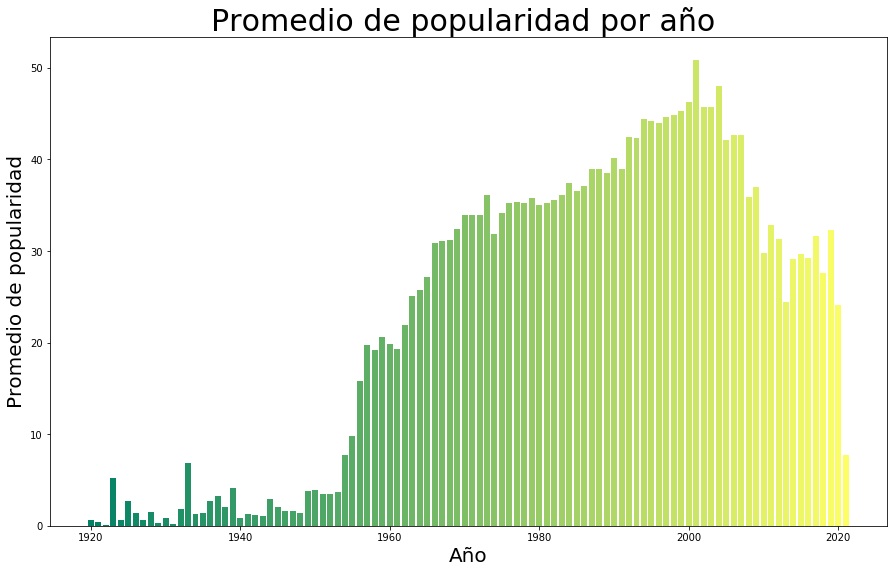

In [18]:
plt.bar(año,popularidad, color = sns.color_palette("summer",len(año)))
plt.title('Promedio de popularidad por año ', fontweight = 30, fontsize = 30)
plt.xlabel('Año',fontsize = 20)
plt.ylabel('Promedio de popularidad', fontsize = 20)

**Evolucion de las distintas componentes de una cancion con respecto al tiempo**

In [19]:
acustico = []
bailabilidad = []
energia = []
instrumental = []
hablar = []
en_vivo = []
valance = []
for i in range (1920,2022):
    filtrar = data[data['year'] == i]
    promedio = filtrar.acousticness.mean()
    acustico.append(promedio)
    promedio = filtrar.danceability.mean()
    bailabilidad.append(promedio)
    promedio = filtrar.energy.mean()
    energia.append(promedio)
    promedio = filtrar.instrumentalness.mean()
    instrumental.append(promedio)
    promedio = filtrar.speechiness.mean()
    hablar.append(promedio)
    promedio = filtrar.liveness.mean()
    en_vivo.append(promedio)
    promedio = filtrar.valence.mean()
    valance.append(promedio)

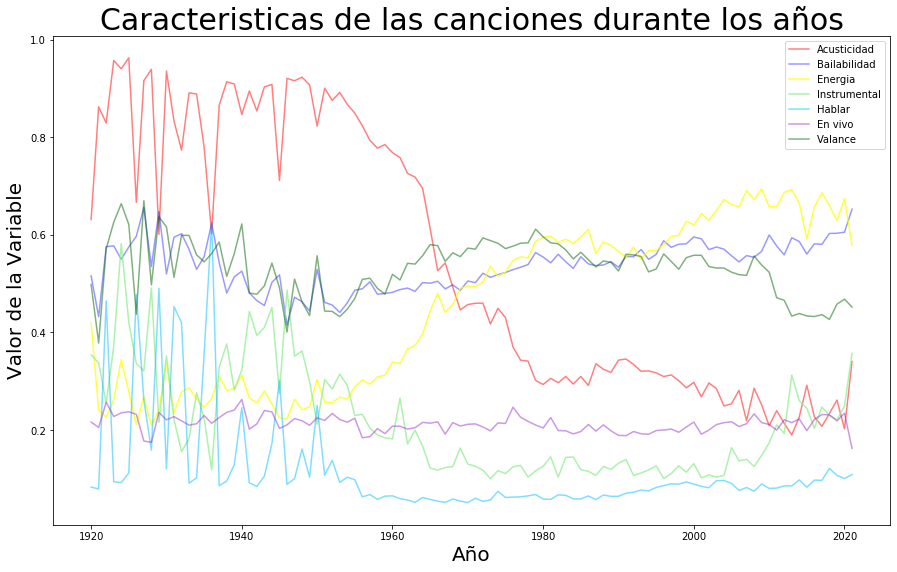

In [20]:
fig, ax = plt.subplots()
ax.plot(año, acustico,color="red",alpha= 0.50)
ax.plot(año, bailabilidad,color = "blue",alpha= 0.40)
ax.plot(año, energia,color = "yellow",alpha= 0.75)
ax.plot(año, instrumental,color = "lightgreen",alpha= 0.75)
ax.plot(año,hablar, color = "deepskyblue",alpha= 0.50)
ax.plot(año,en_vivo,color = "darkorchid",alpha=0.50)
ax.plot(año, valance, color = "darkgreen",alpha= 0.50)
ax.legend(['Acusticidad', 'Bailabilidad',"Energia", "Instrumental","Hablar","En vivo","Valance"])
ax.set_title('Caracteristicas de las canciones durante los años', fontsize= 30)

ax.set_xlabel('Año', fontsize=20)
ax.set_ylabel('Valor de la Variable', fontsize=20)
plt.show()

### Clases

In [6]:
data.popularity.unique()

array([ 12,   7,   4,  17,   2,   9,   5,   0,   8,   1,   3,  13,   6,
        41,  37,  29,  25,  26,  27,  30,  23,  22,  21,  20,  16,  15,
        11,  10,  36,  24,  19,  14,  47,  44,  39,  33,  50,  46,  31,
        18,  51,  35,  34,  28,  38,  32,  63,  53,  49,  42,  43,  40,
        45,  59,  80,  56,  54,  48,  55,  74,  64,  61,  52,  73,  65,
        68,  58,  62,  67,  60,  66,  57,  85,  79,  71,  72,  70,  69,
        84,  75,  77,  81,  82,  87,  78,  76,  83,  86,  90,  89,  88,
        91,  96,  94,  93,  92,  95, 100])

/home/oscar/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

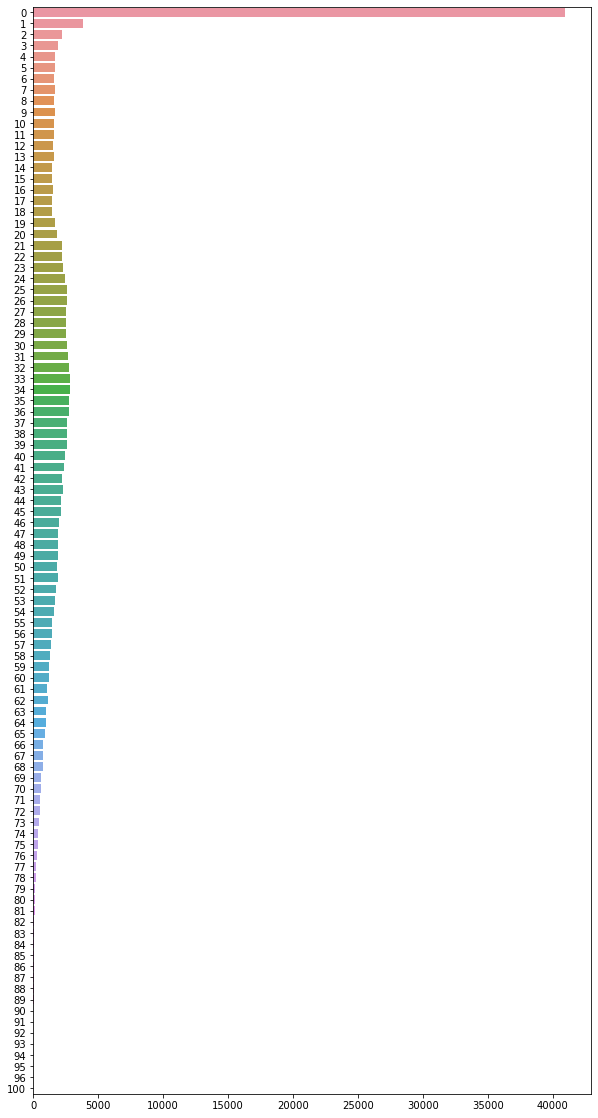

In [25]:
fig, ax = plt.subplots(figsize = (10,20))
x = data.popularity.value_counts().values
y = data.popularity.value_counts().keys()

sns.barplot(x,y, ax=ax, orient = "h")

### Nulos

In [8]:
data.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

### Preparación de los datos

In [4]:
quitar = ["popularity", "artists", "id", "release_date", "name"]
variables = data.drop(columns=quitar).columns
X = data.drop(columns=quitar).values
y = data["popularity"].values

In [5]:
X_notest, X_test, y_notest, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [6]:
sc = StandardScaler()
X_notest_st = sc.fit_transform(X_notest)
X_test_st = sc.transform(X_test)

# Análisis y visualizaciones

In [7]:
def reducir(X_train, y_train=None, X_test=None, y_test=None, k=2, metodo="", verbose=False):
    """Realiza reducción de dimensionalidad por PCA, SVD o LDA
    Parámetros:
        X_train: arreglo 2D
        Los datos con los que se inferirá y aplicará la reducción
        
        y_train: arreglo 1D, default=None
        Etiquetas de los datos, solamente usado con LDA
        
        X_test: arreglo 2D, default=None
        Datos a los que se les aplicará la transformación
        
        y_test: arreglo 1D, default=None
        Etiquetas para X_test, solamente usado con LDA
        
        k: int, default=2
        Número de dimensiones a la que se reducirá la información
        
        Método: {"pca", "svd", "lda"}
        El nombre del método a utilizar
        
        Verbose: bool, default=False
        Si se elige PCA o SVD, imprime la varianza explicada conseguida
        
    Regresa:
        X_train_r: arreglo 2D
        Datos tras haberse aplicado la reducción con la técnica elegida
        
        X_test_r: arreglo 2D
        Los otros datos con la reducción tras haberse aplicado la técnica, si es que hay
    """
    transformadores = {"pca":PCA, "svd":TruncatedSVD, "lda":LinearDiscriminantAnalysis}
    metodo = metodo.lower()
    if metodo not in transformadores:
        raise ValueError("Ponle un valor chido al método")
        
    transformador = transformadores[metodo](n_components=k)
    X_train_r = transformador.fit_transform(X=X_train, y=y_train)
    if verbose and metodo != "lda":
        print("Varianza explicada: ", 
              transformador.explained_variance_ratio_.sum())
        
    if X_test is not None:
        X_test_r = transformador.transform(X_test)
        return X_train_r, X_test_r
    
    return X_train_r

In [8]:
def correlaciones_componentes(original, componentes):
    n_rows, n_cols = original.shape
    _, n_comps = componentes.shape # n_rows, n_comps
    correlaciones = np.corrcoef(original, componentes, rowvar=False)
    return correlaciones[:-n_comps, n_cols:]

In [9]:
def plot_correlaciones(original, componentes, nombres):
    """Grafica las correlaciones entre las variables y componentes principales
    Parámetros:
        original: arreglo 2D
        Los datos originales, antes de la reducción
        
        componentes: arreglo 2d
        Los datos tras la reducción
        
        nombres: lista
        Nombre de las variables
        
    Regresa:
        Figura de plotly con las correlaciones dibujadas con las primeras dos componentes
    """
    correlaciones = correlaciones_componentes(original, componentes)
    df = pd.DataFrame(correlaciones, columns=["PC 1", "PC 2"], index=nombres)
    df["size"] = df["PC 1"]**2 + df["PC 2"]**2
    
    # Scatterplot de las correlaciones
    ar = 800
    fig = px.scatter(df, x="PC 1", y="PC 2", size="size", text=nombres,
                     width=ar, height=ar)
    
    # Circulo unitario
    θ = np.linspace(0, 2*np.pi, 100)
    fig.add_trace(
        go.Scatter(
            x=np.cos(θ),
            y=np.sin(θ),
            mode="lines",
            line=go.scatter.Line(color="red", dash="dash"),
            showlegend=False,
            hoverinfo="skip")
    )
    
    # Ejes coordenados
    fig.add_hline(0, opacity=0.3)
    fig.add_vline(0, opacity=0.3)
    #fig.show()
    return fig

## Con PCA

In [ ]:
X_notest_r, X_test_r = reducir(X_notest_st, y_notest, X_test_st, y_test, k = 2, metodo="pca", verbose=True)

plot_correlaciones(X_notest_st, X_notest_r, variables)

In [ ]:
X_notest_r, X_test_r = reducir(X_notest,y_notest, X_test, y_test, k = 3, metodo="pca")

fig = go.Figure(data = go.Scatter3d(x = X_notest_r[:,0], y = X_notest_r[:,1], z = X_notest_r[:,2], 
                                     mode = "markers", marker = {"color": y_notest, "size": 1}))
fig.show()

## Con SVD

In [207]:
X_notest_r, X_test_r = reducir(X_notest_st, y_notest, X_test_st, y_test, k = 2, metodo="svd", verbose=True)

plot_correlaciones(X_notest_st, X_notest_r, variables)

Varianza explicada:  0.36547863481636433


In [ ]:
X_notest_r, X_test_r = reducir(X_notest,y_notest, X_test, y_test, k = 3, metodo="svd")

fig = go.Figure(data = go.Scatter3d(x = X_notest_r[:,0], y = X_notest_r[:,1], z = X_notest_r[:,2], 
                                     mode = "markers", marker = {"color": y_notest, "size": 1}))
fig.show()

## Con LDA

In [208]:
X_notest_r, X_test_r = reducir(X_notest_st, y_notest, X_test_st, y_test, k = 2, metodo="lda", verbose=True)

plot_correlaciones(X_notest_st, X_notest_r, variables)

In [ ]:
X_notest_r, X_test_r = reducir(X_notest,y_notest, X_test, y_test, k = 3, metodo="lda")

fig = go.Figure(data = go.Scatter3d(x = X_notest_r[:,0], y = X_notest_r[:,1], z = X_notest_r[:,2], 
                                     mode = "markers", marker = {"color": y_notest, "size": 1}))
fig.show()

# Modelos

In [8]:
def probar_metodo(estimador, X_notest, y_notest, X_test, y_test, 
                  k=None, metodo=None, **estimator_params):
    
    if k and metodo:
        X_notest_r, X_test_r = reducir(X_notest, y_notest, 
                                       X_test, y_test, 
                                       k = k, metodo=metodo)
        X_notest, X_test = X_notest_r, X_test_r

    kf = KFold(n_splits=4)

    scores_fold = []
    modelos = []
    for train_index, valid_index in kf.split(X_notest, y_notest):
        X_train, X_valid = X_notest[train_index,:], X_notest[valid_index,:]
        y_train, y_valid = y_notest[train_index], y_notest[valid_index]

        modelo = estimador(**estimator_params)
        modelo.fit(X_train, y_train)
        
        modelos.append(modelo)
        y_pred = modelo.predict(X_valid)
        scores_fold.append(r2_score(y_valid, y_pred))

    nombre_estimador = modelo.__class__.__name__
    print(f"{nombre_estimador} con {metodo}")
    print(f"R^2: {np.mean(scores_fold)} +- {np.std(scores_fold)}")
    
    best_i = np.argmax(scores_fold)
    best_model = modelos[best_i]
    best_score = scores_fold[best_i]
    
    print(f"Test: {best_model.score(X_test, y_test)}")
    
    return best_model

# Regresión lineal
### PCA

In [71]:
%%time
probar_metodo(LinearRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="pca")

LinearRegression con pca
R^2: 0.2640052484501131 +- 0.0022675107294706097
Test: 0.27323753660597505
CPU times: user 2.7 s, sys: 60 ms, total: 2.76 s
Wall time: 771 ms


LinearRegression()

In [72]:
%%time
probar_metodo(LinearRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="pca")

LinearRegression con pca
R^2: 0.2260871965548179 +- 0.0071009439668662504
Test: 0.2346719444150248
CPU times: user 994 ms, sys: 20 ms, total: 1.01 s
Wall time: 180 ms


LinearRegression()

### SVD

In [73]:
%%time
probar_metodo(LinearRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="svd")

LinearRegression con svd
R^2: 0.26191278096340553 +- 0.0023531695773168974
Test: 0.2710588571406948
CPU times: user 1.15 s, sys: 43.9 ms, total: 1.19 s
Wall time: 216 ms


LinearRegression()

In [74]:
%%time
probar_metodo(LinearRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="svd")

LinearRegression con svd
R^2: 0.22926403334745057 +- 0.007047246844420827
Test: 0.23750705709828734
CPU times: user 1.3 s, sys: 7.93 ms, total: 1.31 s
Wall time: 240 ms


LinearRegression()

### LDA

In [75]:
%%time
probar_metodo(LinearRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="lda")

LinearRegression con lda
R^2: 0.36184019708173365 +- 0.004650323828497517
Test: 0.36856598690593967
CPU times: user 1.34 s, sys: 35.7 ms, total: 1.37 s
Wall time: 281 ms


LinearRegression()

In [76]:
%%time
probar_metodo(LinearRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="lda")

LinearRegression con lda
R^2: 0.36184019708173365 +- 0.004650323828497695
Test: 0.36856598690593967
CPU times: user 1.63 s, sys: 23.7 ms, total: 1.65 s
Wall time: 339 ms


LinearRegression()

En regresión lineal, **estandarizar no ayuda** y el mejor método para reducir es **LDA**

# Polinomial

In [146]:
PolinomialRegression = Pipeline
pasos = [("poly_features", PolynomialFeatures(degree=3)),
         ("model", LinearRegression())]

### PCA

In [78]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="pca", steps=pasos)

Pipeline con pca
R^2: 0.30265247808917445 +- 0.0056976863079101795
Test: 0.3044275268182929
CPU times: user 2.2 s, sys: 31.3 ms, total: 2.23 s
Wall time: 403 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [79]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="pca", steps=pasos)

Pipeline con pca
R^2: 0.3736436746016004 +- 0.003527303929376934
Test: 0.37536451920163405
CPU times: user 2.15 s, sys: 15.5 ms, total: 2.17 s
Wall time: 389 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

### SVD

In [80]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="svd", steps=pasos)

Pipeline con svd
R^2: 0.38844883698830124 +- 0.0027886622209538823
Test: 0.3951392348908771
CPU times: user 2.33 s, sys: 31.7 ms, total: 2.36 s
Wall time: 427 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [81]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="svd", steps=pasos)

Pipeline con svd
R^2: 0.24242200797003532 +- 0.006337496594423597
Test: 0.24852300919184644
CPU times: user 2.3 s, sys: 31.3 ms, total: 2.34 s
Wall time: 434 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

### LDA

In [82]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest, y_notest, 
                   X_test, y_test, 
                   k = 3, metodo="lda", steps=pasos)

Pipeline con lda
R^2: 0.40351233505867296 +- 0.002673981948807353
Test: 0.406888981705244
CPU times: user 2.24 s, sys: 41.1 ms, total: 2.28 s
Wall time: 409 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [83]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, 
                   k = 3, metodo="lda", steps=pasos)

Pipeline con lda
R^2: 0.4035123350586768 +- 0.0026739819488078285
Test: 0.40688898170524745
CPU times: user 2.46 s, sys: 51.8 ms, total: 2.51 s
Wall time: 468 ms


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

Con polinomios de tercer grado, realmente **estandarizar no ayudó** (solamente un poquito con PCA).

El mejor método para reducir fue con **LDA**

# K-nn regressor

### PCA

In [84]:
%%time
probar_metodo(KNeighborsRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="pca", n_neighbors=10)

KNeighborsRegressor con pca
R^2: 0.27302025968648413 +- 0.0006544103886522212
Test: 0.28298058497098577
CPU times: user 2.84 s, sys: 36 ms, total: 2.87 s
Wall time: 1.3 s


KNeighborsRegressor(n_neighbors=10)

In [85]:
%%time
probar_metodo(KNeighborsRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="pca", n_neighbors=10)

KNeighborsRegressor con pca
R^2: 0.3646774932717302 +- 0.0014641307238285552
Test: 0.36775010091819194
CPU times: user 2.79 s, sys: 51.6 ms, total: 2.84 s
Wall time: 1.22 s


KNeighborsRegressor(n_neighbors=10)

### SVD

In [86]:
%%time
probar_metodo(KNeighborsRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="svd", n_neighbors=10)

KNeighborsRegressor con svd
R^2: 0.27180944722693845 +- 0.0008436563815081078
Test: 0.2819016410375432
CPU times: user 2.73 s, sys: 40.1 ms, total: 2.77 s
Wall time: 1.18 s


KNeighborsRegressor(n_neighbors=10)

In [87]:
%%time
probar_metodo(KNeighborsRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="svd", n_neighbors=10)

KNeighborsRegressor con svd
R^2: 0.24791943432227204 +- 0.005116513240249737
Test: 0.2518084495947114
CPU times: user 2.79 s, sys: 31.7 ms, total: 2.82 s
Wall time: 1.21 s


KNeighborsRegressor(n_neighbors=10)

### LDA

In [88]:
%%time
probar_metodo(KNeighborsRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="lda", n_neighbors=10)

KNeighborsRegressor con lda
R^2: 0.448627992670915 +- 0.003253402757407348
Test: 0.45474888025937976
CPU times: user 2.31 s, sys: 12 ms, total: 2.32 s
Wall time: 1.28 s


KNeighborsRegressor(n_neighbors=10)

In [89]:
%%time
probar_metodo(KNeighborsRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="lda", n_neighbors=10)

KNeighborsRegressor con lda
R^2: 0.44862801122775714 +- 0.003253384235854219
Test: 0.45474903855090953
CPU times: user 2.33 s, sys: 20.2 ms, total: 2.35 s
Wall time: 1.28 s


KNeighborsRegressor(n_neighbors=10)

Con K-vecinos, podemos decir que **estandarizar sí ayudó** ya que tanto en PCA como SVD fue beneficioso (aunque tampoco tanto) y con LDA fue indiferente.

La mejor metodología fue **LDA**

# Árbol de decisión

### PCA

In [90]:
%%time
probar_metodo(DecisionTreeRegressor,X_notest, y_notest, X_test, y_test,
             k=3, metodo= "pca", max_depth=9)

DecisionTreeRegressor con pca
R^2: 0.48856585895591076 +- 0.0055924079677644595
Test: 0.4961100777158407
CPU times: user 2.78 s, sys: 7.6 ms, total: 2.78 s
Wall time: 1.16 s


DecisionTreeRegressor(max_depth=9)

In [91]:
%%time
probar_metodo(DecisionTreeRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "pca", max_depth=9)

DecisionTreeRegressor con pca
R^2: 0.38425960172259666 +- 0.003636932450980379
Test: 0.3837896018733463
CPU times: user 2.77 s, sys: 23.8 ms, total: 2.79 s
Wall time: 1.1 s


DecisionTreeRegressor(max_depth=9)

### SVD

In [92]:
%%time
probar_metodo(DecisionTreeRegressor, X_notest, y_notest, X_test, y_test,
             k=3, metodo= "svd", max_depth=11)

DecisionTreeRegressor con svd
R^2: 0.2883064986752788 +- 0.005901891227712695
Test: 0.30334763150790733
CPU times: user 2.81 s, sys: 36.2 ms, total: 2.85 s
Wall time: 1.29 s


DecisionTreeRegressor(max_depth=11)

In [93]:
%%time
probar_metodo(DecisionTreeRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "svd", max_depth=11)

DecisionTreeRegressor con svd
R^2: 0.2508738966652143 +- 0.004001637726998574
Test: 0.2579297040835271
CPU times: user 3.08 s, sys: 31.7 ms, total: 3.11 s
Wall time: 1.29 s


DecisionTreeRegressor(max_depth=11)

### LDA

In [94]:
%%time
probar_metodo(DecisionTreeRegressor,X_notest, y_notest, X_test, y_test,
             k=3, metodo= "lda", max_depth=9)

DecisionTreeRegressor con lda
R^2: 0.4559411643782788 +- 0.005147976272303773
Test: 0.4637234161567979
CPU times: user 2.16 s, sys: 36.3 ms, total: 2.2 s
Wall time: 1.11 s


DecisionTreeRegressor(max_depth=9)

In [95]:
%%time
probar_metodo(DecisionTreeRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "lda", max_depth=9)

DecisionTreeRegressor con lda
R^2: 0.45615847971392975 +- 0.005379658273682694
Test: 0.4642268524500506
CPU times: user 2.14 s, sys: 12 ms, total: 2.15 s
Wall time: 1.14 s


DecisionTreeRegressor(max_depth=9)

Para árboles de decisión, en general podemos decir que **estandarizar no ayudó**, ya que en PCA le fue peor, en SVD ayudó tantito y en LDA fue indiferente.

La mejor metodología fue **PCA**

# Random Forest

### PCA

In [96]:
%%time
probar_metodo(RandomForestRegressor, X_notest, y_notest, X_test, y_test,
             k=3, metodo= "pca", n_estimators = 31, random_state = 0)

RandomForestRegressor con pca
R^2: 0.5157523493618581 +- 0.0048419038990016846
Test: 0.5254741565369527
CPU times: user 38.7 s, sys: 211 ms, total: 38.9 s
Wall time: 37.4 s


RandomForestRegressor(n_estimators=31, random_state=0)

In [97]:
%%time
probar_metodo(RandomForestRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "pca", n_estimators = 31, random_state = 0)

RandomForestRegressor con pca
R^2: 0.3788892817718722 +- 0.003275456019279962
Test: 0.3835956104431206
CPU times: user 40.5 s, sys: 180 ms, total: 40.6 s
Wall time: 39.2 s


RandomForestRegressor(n_estimators=31, random_state=0)

### SVD

In [98]:
%%time
probar_metodo(RandomForestRegressor, X_notest, y_notest, X_test, y_test,
             k=3, metodo= "svd", n_estimators = 31, random_state = 0)

RandomForestRegressor con svd
R^2: 0.47305136751529386 +- 0.003636777817901041
Test: 0.48029354812160574
CPU times: user 45.4 s, sys: 104 ms, total: 45.5 s
Wall time: 44 s


RandomForestRegressor(n_estimators=31, random_state=0)

In [99]:
%%time
probar_metodo(RandomForestRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "svd", n_estimators = 31, random_state = 0)

RandomForestRegressor con svd
R^2: 0.2631920993632542 +- 0.003826928418654055
Test: 0.25864301989494387
CPU times: user 40.6 s, sys: 148 ms, total: 40.8 s
Wall time: 39.3 s


RandomForestRegressor(n_estimators=31, random_state=0)

### LDA

In [100]:
%%time
probar_metodo(RandomForestRegressor, X_notest, y_notest, X_test, y_test,
             k=3, metodo= "lda", n_estimators = 31, random_state = 0)

RandomForestRegressor con lda
R^2: 0.4640239297740527 +- 0.004150582027362178
Test: 0.4730679403231738
CPU times: user 41.1 s, sys: 59.8 ms, total: 41.2 s
Wall time: 40.2 s


RandomForestRegressor(n_estimators=31, random_state=0)

In [101]:
%%time
probar_metodo(RandomForestRegressor, X_notest_st, y_notest, X_test_st, y_test,
             k=3, metodo= "lda", n_estimators = 31, random_state = 0)

RandomForestRegressor con lda
R^2: 0.4640239297740527 +- 0.004150582027362178
Test: 0.4730679403231738
CPU times: user 40.4 s, sys: 156 ms, total: 40.6 s
Wall time: 39.8 s


RandomForestRegressor(n_estimators=31, random_state=0)

Para RandomForest, **estandarizar no fue de ayuda**.

El mejor método para reducir fue **PCA**

# GBT

### PCA

In [102]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="pca", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con pca
R^2: 0.46574607587115613 +- 0.0050116511685733235
Test: 0.47133351864180784
CPU times: user 9.41 s, sys: 31.8 ms, total: 9.44 s
Wall time: 7.92 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

In [103]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="pca", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con pca
R^2: 0.3744863535403422 +- 0.006086798439417348
Test: 0.37962194741450317
CPU times: user 9.48 s, sys: 29.2 ms, total: 9.51 s
Wall time: 8.05 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

### SVD

In [104]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="svd", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con svd
R^2: 0.26720199269917 +- 0.0012467928510788513
Test: 0.269704911394694
CPU times: user 9.7 s, sys: 32.6 ms, total: 9.73 s
Wall time: 8.24 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

In [105]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="svd", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con svd
R^2: 0.25520186569086856 +- 0.0049415299268875355
Test: 0.26111552842601515
CPU times: user 9.67 s, sys: 43.6 ms, total: 9.71 s
Wall time: 8.16 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

### LDA

In [106]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest, y_notest, X_test, y_test, 
                  k=3, metodo="lda", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con lda
R^2: 0.4437121746800048 +- 0.005654737367492657
Test: 0.4484815864430197
CPU times: user 9.11 s, sys: 48.2 ms, total: 9.16 s
Wall time: 8.18 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

In [107]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  k=3, metodo="lda", n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con lda
R^2: 0.4437121746800048 +- 0.005654737367492657
Test: 0.4484815864430197
CPU times: user 9.05 s, sys: 23.9 ms, total: 9.08 s
Wall time: 8.23 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

Con Gradient Boosting Machine vemos que en PCA empeoró, en SVD sí mejoró y en LDA fue indiferente, por lo que podemos decir que, en general, **estandarizar no ayudó**.

Se alcanzó mejores resultados con **PCA**

# LGBM

### PCA

In [108]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest, y_notest, X_test, y_test, k=3, metodo="pca", 
              boosting_type="dart", n_estimators=31, learning_rate=1.95)

LGBMRegressor con pca
R^2: 0.047352449577081096 +- 0.019373112925562447
Test: 0.050175506844550744
CPU times: user 4.78 s, sys: 108 ms, total: 4.89 s
Wall time: 962 ms


LGBMRegressor(boosting_type='dart', learning_rate=1.95, n_estimators=31)

In [109]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest_st, y_notest, X_test_st, y_test, k=3, metodo="pca", 
              boosting_type="dart", n_estimators=31, learning_rate=1.95)

LGBMRegressor con pca
R^2: 0.02573107255799667 +- 0.00973646363499737
Test: 0.02679881976400489
CPU times: user 4.36 s, sys: 51.4 ms, total: 4.41 s
Wall time: 834 ms


LGBMRegressor(boosting_type='dart', learning_rate=1.95, n_estimators=31)

### SVD

In [110]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest, y_notest, X_test, y_test, k=3, metodo="svd", 
              boosting_type="dart", n_estimators=31, learning_rate=2.15)

LGBMRegressor con svd
R^2: -6.233646443780534 +- 0.09855816068573812
Test: -6.168702294750761
CPU times: user 4.05 s, sys: 51.9 ms, total: 4.11 s
Wall time: 763 ms


LGBMRegressor(boosting_type='dart', learning_rate=2.15, n_estimators=31)

In [111]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest_st, y_notest, X_test_st, y_test, k=3, metodo="svd", 
              boosting_type="dart", n_estimators=31, learning_rate=2.15)

LGBMRegressor con svd
R^2: -6.859726322439025 +- 0.07278221420479009
Test: -6.766730251916532
CPU times: user 4.05 s, sys: 72 ms, total: 4.13 s
Wall time: 758 ms


LGBMRegressor(boosting_type='dart', learning_rate=2.15, n_estimators=31)

### LDA

In [112]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest, y_notest, X_test, y_test, k=3, metodo="lda", 
              boosting_type="dart", n_estimators=31, learning_rate=1.95)

LGBMRegressor con lda
R^2: 0.02882809643943912 +- 0.0072701717618820485
Test: 0.037745985319599495
CPU times: user 5.61 s, sys: 84.2 ms, total: 5.69 s
Wall time: 1.16 s


LGBMRegressor(boosting_type='dart', learning_rate=1.95, n_estimators=31)

In [113]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest_st, y_notest, X_test_st, y_test, k=3, metodo="lda", 
              boosting_type="dart", n_estimators=31, learning_rate=1.95)

LGBMRegressor con lda
R^2: 0.02882809643943912 +- 0.0072701717618820485
Test: 0.037745985319599495
CPU times: user 4.22 s, sys: 63.9 ms, total: 4.28 s
Wall time: 806 ms


LGBMRegressor(boosting_type='dart', learning_rate=1.95, n_estimators=31)

En LGBM podemos decir que **estandarizar no ayudó**

la mejor metodología fue **PCA**

Hay algo raro con este modelo, ya que parece ser que si usas su propio score, da otras cosas

-------------------

En general, creo que estandarizar no resultó útil

De 7 modelos, con 4 (curiosamente los relacionados a árboles) resultó mejor usar PCA y con los otros 3 usar LDA.


---------------

Actualización:
La reducción de dimensionalidad no nos está resultando útil.
* Si no se hace la estandarización, resulta que la variabilidad se la lleva principalmente la variable de duración, porque está en milisegundos y eso hace que se tengan valores grandes en comparación con las otras. Con una sola componente ya se tenía el 99% de la variabilidad

* Si se realiza la estandarización, se resuelve el problema anterior, pero el problema es que con 3 componentes solamente se consigue explicar el 46% de la varianza, lo cual puede explicar porque "no está ayudando" la estandarización.

Lo que se debería probar ahora es usar las variables estandarizadas **sin** reducción

In [145]:
%%time
probar_metodo(LinearRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test)

LinearRegression con None
R^2: 0.3617012768308049 +- 0.004628755577700512
Test: 0.3684928688975093
CPU times: user 242 ms, sys: 26.4 ms, total: 269 ms
Wall time: 957 ms


LinearRegression()

In [148]:
%%time
probar_metodo(PolinomialRegression, 
                   X_notest_st, y_notest, 
                   X_test_st, y_test, steps=pasos)

Pipeline con None
R^2: 0.5928718917386039 +- 0.0021899766903692532
Test: 0.5913477160438305
CPU times: user 44.4 s, sys: 3.75 s, total: 48.2 s
Wall time: 13.3 s


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [149]:
%%time
probar_metodo(KNeighborsRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  n_neighbors=10)

KNeighborsRegressor con None
R^2: 0.5401158770759624 +- 0.0020193106951685554
Test: 0.5393321183496611
CPU times: user 2min 45s, sys: 145 ms, total: 2min 45s
Wall time: 2min 45s


KNeighborsRegressor(n_neighbors=10)

In [168]:
%%time
tree = probar_metodo(DecisionTreeRegressor, X_notest_st, y_notest, X_test_st, y_test,
                     max_depth=9)

DecisionTreeRegressor con None
R^2: 0.5974288640666096 +- 0.005138552586204295
Test: 0.6011083371940336
CPU times: user 2.42 s, sys: 23.7 ms, total: 2.45 s
Wall time: 2.98 s


In [169]:
%%time
random_forest = probar_metodo(RandomForestRegressor, X_notest_st, y_notest, X_test_st, y_test,
                               n_estimators = 31, random_state = 0)

RandomForestRegressor con None
R^2: 0.6691521524160086 +- 0.004136119138327282
Test: 0.6709557084992585
CPU times: user 1min 49s, sys: 1.07 s, total: 1min 50s
Wall time: 1min 51s


In [152]:
%%time
probar_metodo(GradientBoostingRegressor, X_notest_st, y_notest, X_test_st, y_test, 
                  n_estimators=31, learning_rate=1.0, max_depth=2, random_state=42)

GradientBoostingRegressor con None
R^2: 0.5985679461792845 +- 0.00594668728787715
Test: 0.6034899340050586
CPU times: user 18.1 s, sys: 0 ns, total: 18.1 s
Wall time: 18.1 s


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=31,
                          random_state=42)

In [153]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest_st, y_notest, X_test_st, y_test, 
              boosting_type="dart", n_estimators=31, learning_rate=1.95)

LGBMRegressor con None
R^2: 0.02284778422656286 +- 0.013179546868704092
Test: 0.021201253132549946
CPU times: user 3.72 s, sys: 43.1 ms, total: 3.76 s
Wall time: 1.56 s


LGBMRegressor(boosting_type='dart', learning_rate=1.95, n_estimators=31)

# Búsqueda de hiperpárametros

## Random Forest

In [163]:
params = {"n_estimators":[25,50,75,100],
          "max_depth":[6,9,12,15],
          "min_samples_leaf":[1,2,4,8], 
          "bootstrap":[True, False]}

combinaciones = np.prod([len(l_params) for _,l_params in params.items()])
combinaciones

128

In [165]:
%%time
search_rf = RandomizedSearchCV(RandomForestRegressor(max_samples=0.75, random_state=0), params,
                             n_iter=64, n_jobs=-1, cv=4, verbose=0)
search_rf.fit(X_notest_st, y_notest)

print(search_rf.best_score_)
search_rf.best_params_

0.6692361637561233
CPU times: user 1min 3s, sys: 179 ms, total: 1min 3s
Wall time: 26min 18s


{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_depth': 15,
 'bootstrap': True}

## Gradient Boosting Machine

In [56]:
params = {"loss":["ls", "lad", "huber"],
          "learning_rate":[0.1, 0.01],
          "n_estimators":[25,50,100,150],
          "subsample":[1.0, 0.75],
          "min_samples_leaf":[2,4,8]}

In [57]:
%%time
grid_gbm = GridSearchCV(GradientBoostingRegressor(random_state=3,
                                              n_iter_no_change=10), 
                    params, n_jobs=-1, cv=4, verbose=0)
grid_gbm.fit(X_notest_r, y_notest)

print(grid_gbm.best_score_)
grid_gbm.best_params_

0.503651768367076
CPU times: user 13.5 s, sys: 182 ms, total: 13.7 s
Wall time: 12min 1s


{'learning_rate': 0.1,
 'loss': 'ls',
 'min_samples_leaf': 2,
 'n_estimators': 150,
 'subsample': 0.75}

## LGBM

In [86]:
%%time
lgbm = lgb.LGBMRegressor(boosting_type="dart")
distributions = dict(learning_rate=uniform(1.,3), 
                     sub_feature=uniform(0, 2), num_leaves=randint(20, 300),
                     min_data=randint(20, 100), max_depth=randint(5, 200),
                     n_estimators=randint(10, 81))
clf = RandomizedSearchCV(lgbm, distributions, random_state=42, n_iter=1000,n_jobs=-1,cv=4,scoring="r2")

search = clf.fit(X_notest_st, y_notest)
search.best_params_

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.6089808487080608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089808487080608
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=73. Current value: min_data_in_leaf=73
CPU times: user 9.81 s, sys: 1.85 s, total: 11.7 s
Wall time: 6min 27s


{'learning_rate': 1.1913836687607935,
 'max_depth': 87,
 'min_data': 73,
 'n_estimators': 60,
 'num_leaves': 29,
 'sub_feature': 0.6089808487080608}

In [87]:
search.best_score_

0.6150414448273998

In [10]:
%%time
probar_metodo(lgb.LGBMRegressor, X_notest_st, y_notest, X_test_st, y_test,
              boosting_type="dart", learning_rate=1.1237411986340424, max_depth=5, min_data=35,
              n_estimators=79, num_leaves=100, sub_feature=0.9995241316068411)

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.9995241316068411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995241316068411
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.9995241316068411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995241316068411
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.9995241316068411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995241316068411
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=35. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set with sub_feature

LGBMRegressor(boosting_type='dart', learning_rate=1.1237411986340424,
              max_depth=5, min_data=35, n_estimators=79, num_leaves=100,
              sub_feature=0.9995241316068411)

[Vuelve al principio](#Índice)

# Interpretación

In [200]:
importancia = pd.DataFrame(random_forest.feature_importances_, index=variables, columns=["importance"])
importancia.sort_values("importance", ascending=False, inplace=True)
importancia

,importance
year,0.534975
instrumentalness,0.078800
loudness,0.050508
duration_ms,0.047704
energy,0.038958
acousticness,0.037943
danceability,0.036465
liveness,0.036304
valence,0.035960
speechiness,0.034949


Vemos que el año es primordialmente lo importante a la hora de que una canción sea popular o no. Entre otras características, tenemos que la presencia de instrumentos, que tan ruidosa es, la duración de la canción, y la energía son otros aspectos importantes.

In [197]:
data.sort_values("popularity", ascending=False)[["name","popularity", "year"]].head(10)

,name,popularity,year
20062,drivers license,100,2021
19862,Mood (feat. iann dior),96,2020
19866,positions,96,2020
19886,DÁKITI,95,2020
19976,BICHOTA,95,2020
19868,34+35,94,2020
19870,Whoopty,94,2020
19872,WITHOUT YOU,94,2020
19876,Therefore I Am,94,2020
19928,LA NOCHE DE ANOCHE,94,2020


In [211]:
X_total = data.drop(columns=quitar).values
X_total = sc.transform(X_total)

In [212]:
X_total_r = reducir(X_total, k = 2, metodo="pca")

plot_correlaciones(X_total, X_total_r, variables)

Considerando que las canciones más populares son de los últimos años, podemos decir, con ayuda del gráfico anterior, que las canciones tienden a ser más populares si son mas animadas, intrépidas, es decir, que en promedio se tengan amplitudes más grandes, que sean intensas, rápidas. 